# Exploration

Affichage des distributions de chaque capteurs, de leurs corrélations (entre eux) et autocorrélation (avec eux décalés dans le temps), et des centroïdes résultant de k-means sur les time series.
Fait avec ilot1.all.csv, preprocessed avec moyenne 1min.

Je suis pas sur que les visualisations soient bien utiles. Par contre, deux trois trucs que j'ai utilisé vont surement pouvoir resservir :
    - groupby et fillna/dropna, interpolate/scipy.interp1d : pour mettre en fenêtres et "assainir" un peu les données des nan (voir plot_windows)
    - tslearn : metrics, reduction de dimension (sax/paa(cf conférence)), 2-3 classifiers

In [41]:
import numpy as np
from scipy.interpolate import interp1d

import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt


def plot_distributions(df):
    palette = sns.color_palette("husl", 8)
    x = df[df.columns[0]].interpolate()
    interp_x = np.linspace(np.min(x), np.max(x), 100)
    # Plot the values for each sensor.
    #fig = plt.figure()
    for i, col in enumerate(df.columns):
        ax = plt.subplot(len(df.columns), 1, i+1)
        
        y = df[df.columns[i]].interpolate()
        f = interp1d(x, y, kind='slinear')
        interp_y = f(interp_x)
        plt.plot(x, y, alpha=0.2, color=palette[i])
        plt.plot(interp_x, interp_y, alpha=1, color=palette[i])
    plt.show()
        
    
    # Plot histogram and distribution.
    for i, col in enumerate(df.columns):
        ax = plt.subplot(1, len(df.columns), i+1)
        sns.distplot(df[df.columns[i]].interpolate(), color=palette[i]) 
    plt.show()

def plot_correlations(df):
    for i, col in enumerate(df.columns):
        #ax = plt.subplot(1, len(df.columns), i+1)
        
        # Plot autocorrelation of the variable.
        pd.plotting.autocorrelation_plot(df[df.columns[i]].interpolate())
        plt.title("Autocorrelation for "+col)
        plt.show()
    #plt.legend()
    #plt.show()

    # Plot correlation between sensors.
    sns.heatmap(df.corr())
    plt.show()

# Computes autocorrelation for each column of a df, with lag.
def df_autocorr(df, lag=1):
    return list(map(
        lambda x: x.autocorr(lag=lag),
        [df[df.columns[i]] for i in range(len(df.columns))]
    ))


# tslearn offers some useful function for time series.
# Including metrics.
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
def plot_windows(df, length=1):
    df_copy = df.copy()
    # Group by length quanta-of-time windows.
    windows = df.groupby(df_copy['time'] // length * length)
    ts_set = []
    for key, window in windows:
        
        # Only take the series where all observations are present.
        if len(window) == length:
            ts_set.append(window.iloc[:,1:].interpolate().values)
    # Make a TS dataset out of the data. (order 3 tensor)                
    TS = to_time_series_dataset(ts_set)
    print("TS.shape :", TS.shape)

    # Instantiate a scaler (mean=0, variance=1) and transform the data.
    # Necessary because of euclidian-distance k-means.
    scaler = TimeSeriesScalerMeanVariance()
    X = scaler.fit_transform(TS)
    #X = TS
    nb_features = X.shape[2]

    # Plot kmeans clusters for each sensor time series.
    plt.figure()
    for i in range(nb_features):
        # Select the column for the i-th sensor.
        X_train = X[:,:,i]

        kmeans = TimeSeriesKMeans().fit(X_train)

        print("Euclidean k-means")
        nb_clusters = 6
        km = TimeSeriesKMeans(n_clusters=nb_clusters, verbose=True)
        y_pred = km.fit_predict(X_train)

        sz = X_train.shape[1]-1
        # Plot each cluster.
        for yi in range(nb_clusters):
            plt.subplot(nb_clusters, 1, yi + 1)

            # Plot the time series assigned to the cluster.
            for xx in X_train[y_pred == yi]:
                plt.plot(xx.ravel(), "k-", alpha=.005)
            # Plot the centroid.
            plt.plot(km.cluster_centers_[yi].ravel(), "r-")

            plt.xlim(0, sz)
            plt.ylim(-2, 2)
            if yi == 0:
                plt.title("$k$-means for "+str(df.columns[i+1])+" ("+str(length)+"m windows)")
            # Disable the x axis ticks to not clutter the figure.
            if yi != nb_clusters-1:
                plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            #Only plot the 0 (center) tick for the y axis.
            plt.yticks([0])
        plt.show()
 
def plot_pairs(df):
    df_copy = df.copy()
    
    # Quantize the confort column to get better plot colorization.
    df_copy['confort'] = np.floor(df['confort']) # /5 to normalize

    # Create a grid where columns are compared pair-wise.
    # Colors of "plotted stuff" depends on the value of the confort column.
    g = sns.PairGrid(df_copy, hue='confort', palette="RdBu")

    # Plot scatter, histogram and density estimation plots.
    g = g.map_lower(plt.scatter, s=3, alpha=0.2)
    g = g.map_diag(plt.hist, histtype='step', linewidth=1, alpha=0.6)
    g = g.map_upper(sns.kdeplot, alpha=0.4, legend=False)
    g.add_legend()

    plt.show()


path = "../data/"
prep_path = "../data/preprocessed/"
path_parts = path+"parts/"
file_names = [
    'All-All-2017-09-01_2018-09-01.csv',
    'neocampus.lite.csv'
]

file_name = prep_path+"ilot1.all.prep.csv"
df = pd.read_csv(file_name, delimiter=';', nrows=5000)
column_names = [
    "time",
    "",
    "value",
    "time",
    "unit",
    "location"
]

print(df.isnull().any(axis=1).sum(), "rows with nan.")

# Drop rows with missing values.
#df.dropna(inplace=True)

# Rename the timestamp column.
df.rename(columns = {df.columns[0]:"time"}, inplace = True)
#df['time'] = pd.to_datetime(df['time'], unit='m')

print(df.head())
print("dataframe :", df.shape)


16 rows with nan.
       time    co2   hum         lum   temp  confort
0  25085453  357.0   NaN  813.000000  22.93      4.5
1  25085454  381.0  42.0  819.333333  23.00      4.8
2  25085455  344.0  42.0  773.666667  22.48      4.8
3  25085456  338.0  42.0  778.000000  22.83      4.8
4  25085457  351.0  43.0  821.000000  22.76      4.9
dataframe : (5000, 6)


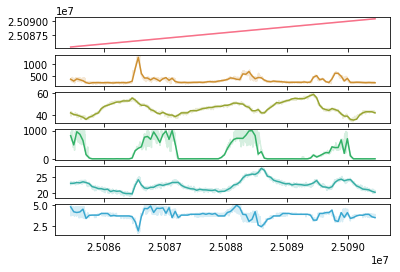

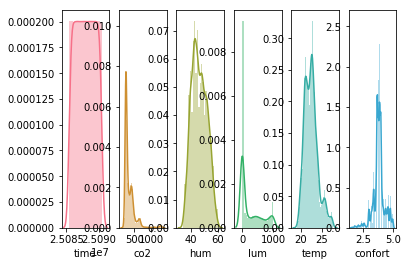

In [42]:
# Plot for each sensor the plot, histogram.
plot_distributions(df.dropna())

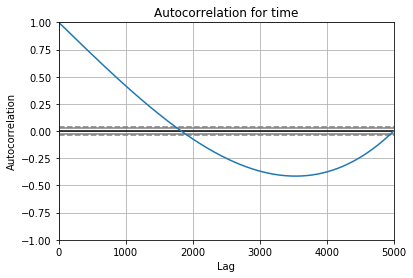

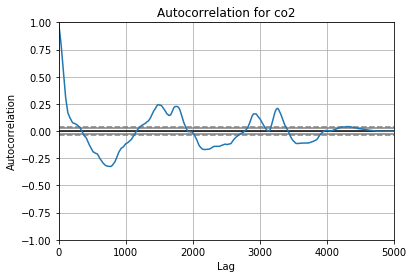

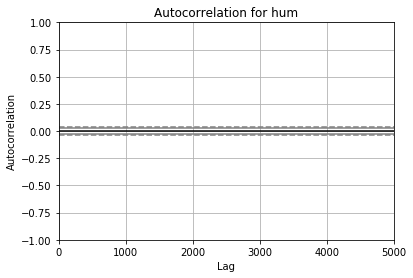

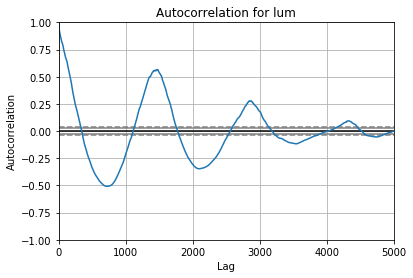

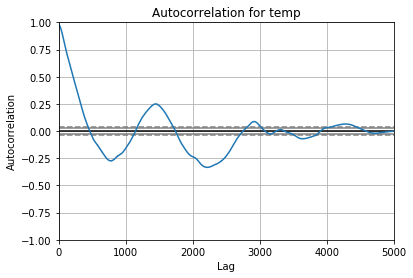

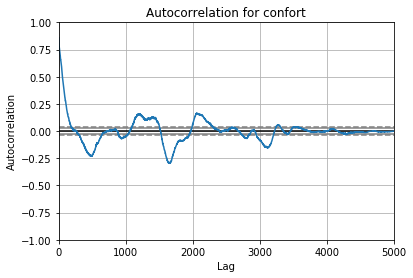

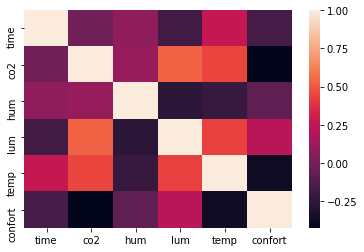

In [46]:
# Plot autocorrelations and a correlation heatmap.
plot_correlations(df)

/home/arche/.conda/envs/dc/lib/python3.7/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/home/arche/.conda/envs/dc/lib/python3.7/site-packages/matplotlib/contour.py:1557: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/arche/.conda/envs/dc/lib/python3.7/site-packages/matplotlib/contour.py:1558: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/arche/.conda/envs/dc/lib/python3.7/site-packages/matplotlib/contour.py:1203: RuntimeWarning: invalid value encountered in less
  under = np.nonzero(lev < self.zmin)[0]
/home/arche/.conda/envs/dc/lib/python3.7/site-packages/matplotlib/contour.py:1205: RuntimeWarning: invalid value encountered in greater
  over = np.nonzero(lev > self.zmax)[0]
/home/arche/.conda/envs/dc/lib/python3.7/site-packages/matplotlib/contour.py:1239: R

/home/arche/.conda/envs/dc/lib/python3.7/site-packages/matplotlib/contour.py:1557: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/arche/.conda/envs/dc/lib/python3.7/site-packages/matplotlib/contour.py:1558: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/arche/.conda/envs/dc/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/arche/.conda/envs/dc/lib/python3.7/site-packages/matplotlib/contour.py:1557: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/arche/.conda/envs/dc/lib/python3.7/site-packages/matplotlib/contour.py:1558: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/arche/.conda/envs/dc/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found 

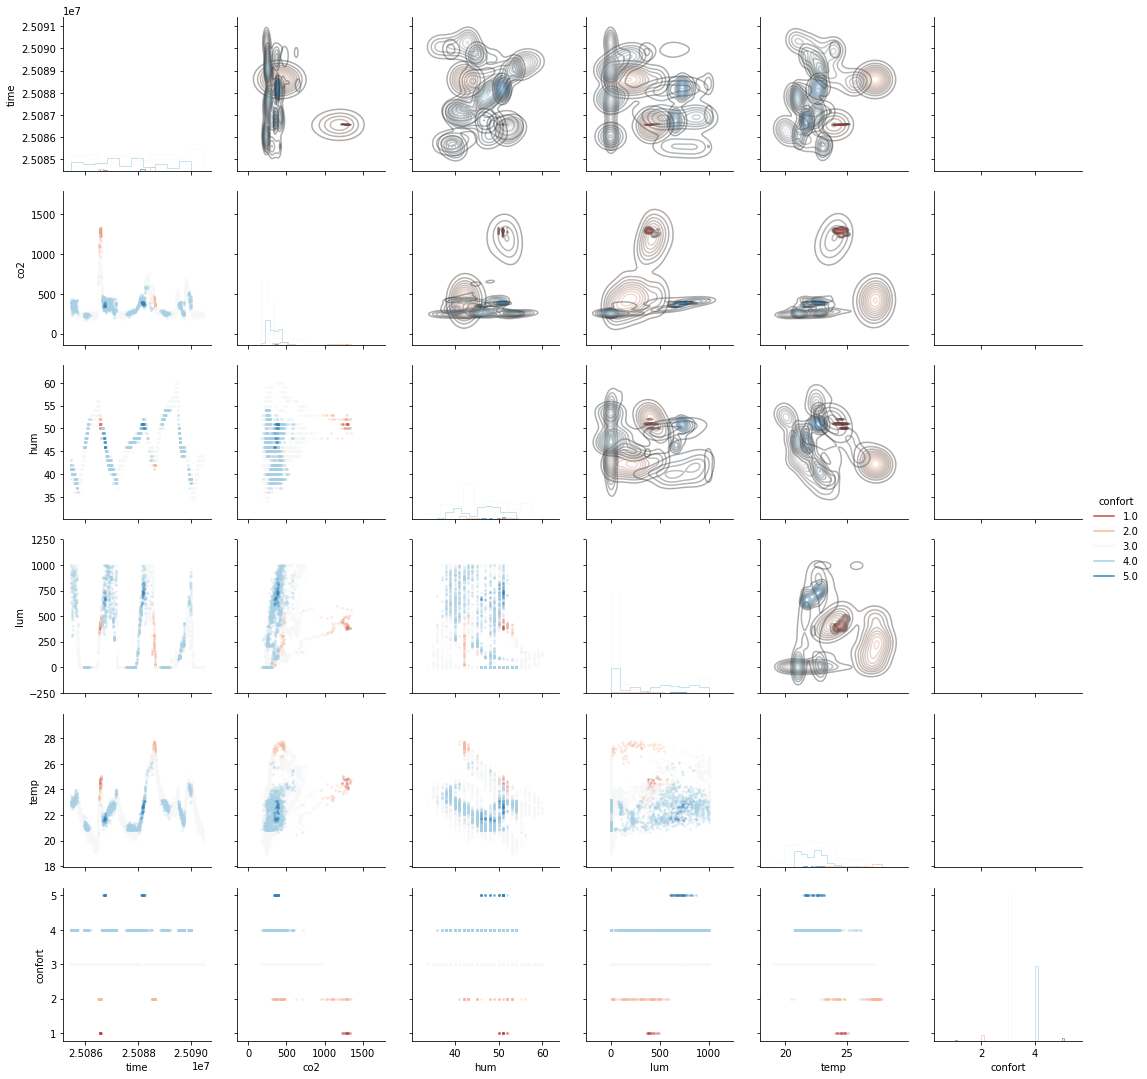

In [45]:
# Plot plots for each pair of columns in the df. Pretty looong. And throws a lot of warnings.
plot_pairs(df.dropna())

In [ ]:
# Plot kmeans clusters. Might have to play with nb_clusters and alpha(based on number of ts)
# to get nice plots. 60m with the whole file gives an okay result
plot_windows(df, 60)